In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from Bio import SeqIO

import pymutspec
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.annotation.spectra import complete_sbs192_columns, get_cossim
from pymutspec.io import read_rates 

In [2]:
coda = CodonAnnotation(2)

## Read and explore NeMu-pipeline output on chordates Cytb seqs

In [24]:
msa = list(SeqIO.parse('./nemu_output/msa.fasta', 'fasta'))
msa = [x for x in msa if not x.id.startswith('Branchiostoma_floridae')]
rates = read_rates('./nemu_output/rates.tsv')
site2rates = dict(enumerate(rates, 1))

In [25]:
# check that msa length and rates dataframe lenth are equal
assert len(rates) == len(msa[0])

In [27]:
# distribution of rate categories in CYTB gene of chordates
pd.Series(rates).value_counts().sort_index()

0    212
1    244
2    128
3     85
4     93
5    174
6    201
dtype: int64

In [28]:
# same, but in percents
pd.Series(rates).value_counts(normalize=True).sort_index().round(4) * 100

0    18.65
1    21.46
2    11.26
3     7.48
4     8.18
5    15.30
6    17.68
dtype: float64

In [29]:
# collect expected mutations freqs for each sequence
exp_lst = []
for rec in msa:
    exp_lst.append(
        coda.collect_exp_muts(str(rec.seq)).assign(species=rec.name)
    )
exp = pd.concat(exp_lst).rename(columns={'Pos': 'Site'})
# assign rate category to each site
exp['rate'] = exp.Site.map(site2rates)
exp

,Site,Pic,Mut,Cdn,Label,species,rate
0,3,3,T[G>A]A,ATG,syn,Rhinopithecus_bieti,1
1,6,3,C[C>A]C,ACC,syn,Rhinopithecus_bieti,4
2,6,3,C[C>G]C,ACC,syn,Rhinopithecus_bieti,4
3,6,3,C[C>T]C,ACC,syn,Rhinopithecus_bieti,4
4,9,3,C[T>C]A,CCT,syn,Rhinopithecus_bieti,4
...,...,...,...,...,...,...,...
801,1129,1,C[C>T]T,CTA,syn,Micropteropus_pusillus,4
802,1131,3,T[A>G]A,CTA,syn,Micropteropus_pusillus,5
803,1131,3,T[A>C]A,CTA,syn,Micropteropus_pusillus,5
804,1131,3,T[A>T]A,CTA,syn,Micropteropus_pusillus,5


In [30]:
#calculate mean number of mutations in each site category
exp.groupby(['species']).rate.value_counts().unstack().fillna(0).mean(0)

rate
0      0.015416
1      1.162384
2      0.420349
3      6.980473
4     51.207605
5    212.782117
6    540.501542
dtype: float64

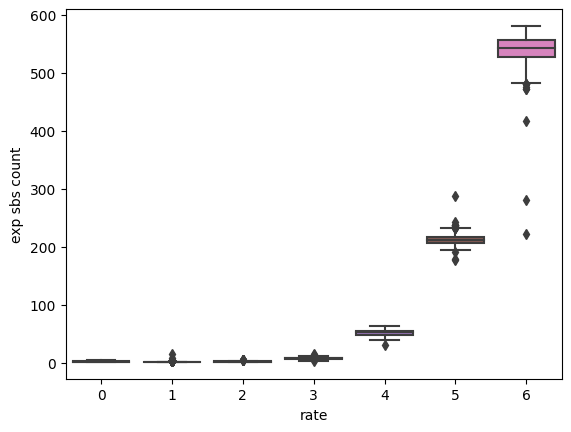

In [31]:
# plot distribution of the number of mutations in each site category 
sns.boxplot(data=exp.groupby(['species']).rate.value_counts().rename('exp sbs count').reset_index(), 
            x='rate', y='exp sbs count');

Process only 4, 5 and 6 rate categories

1, 2 and 3 are almost absent in the expected mutations dataaset

In [32]:
# filter out 1, 2, 3 ratecats
# reformat spectra table to wide format
# replace missing values by zeros
exp_rate_freqs = complete_sbs192_columns(
    exp[exp.rate > 3].groupby(['species', 'rate']).Mut.value_counts().unstack().fillna(0))
exp_rate_freqs

Mut                            A[A>C]A  A[A>C]C  A[A>C]G  A[A>C]T  C[A>C]A  \
species                  rate                                                
Abbottina_obtusirostris  4         0.0      0.0      0.0      0.0      1.0   
                         5         0.0      0.0      0.0      0.0      0.0   
                         6         0.0      0.0      0.0      0.0     10.0   
Abbottina_rivularis      4         0.0      0.0      0.0      0.0      1.0   
                         5         0.0      0.0      0.0      0.0      0.0   
...                                ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5         0.0      0.0      0.0      0.0      2.0   
                         6         0.0      0.0      0.0      0.0      7.0   
Zosterops_japonicus      4         0.0      0.0      0.0      0.0      0.0   
                         5         0.0      0.0      0.0      0.0      2.0   
                         6         0.0      0.0      0.0      0.0      7.0   

Mut                            C[A>C]C  C[A>C]G  C[A>C]T  G[A>C]A  G[A>C]C  \
species                  rate                                                
Abbottina_obtusirostris  4         0.0      0.0      0.0      0.0      0.0   
                         5         3.0      1.0      2.0      1.0      1.0   
                         6         9.0     11.0     15.0      0.0      0.0   
Abbottina_rivularis      4         0.0      0.0      0.0      0.0      0.0   
                         5         2.0      1.0      2.0      1.0      1.0   
...                                ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5         1.0      1.0      3.0      1.0      0.0   
                         6        10.0     11.0     10.0      0.0      2.0   
Zosterops_japonicus      4         0.0      0.0      0.0      0.0      0.0   
                         5         1.0      1.0      3.0      1.0      0.0   
                         6        10.0     10.0     10.0      0.0      3.0   

Mut                            ...  C[T>G]G  C[T>G]T  G[T>G]A  G[T>G]C  \
species                  rate  ...                                       
Abbottina_obtusirostris  4     ...      0.0      0.0      0.0      0.0   
                         5     ...      0.0      0.0      0.0      0.0   
                         6     ...      3.0      0.0      1.0      0.0   
Abbottina_rivularis      4     ...      0.0      0.0      0.0      0.0   
                         5     ...      0.0      1.0      0.0      0.0   
...                            ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5     ...      0.0      2.0      1.0      0.0   
                         6     ...      2.0      2.0      0.0      0.0   
Zosterops_japonicus      4     ...      0.0      0.0      0.0      0.0   
                         5     ...      0.0      2.0      1.0      0.0   
                         6     ...      3.0      6.0      0.0      1.0   

Mut                            G[T>G]G  G[T>G]T  T[T>G]A  T[T>G]C  T[T>G]G  \
species                  rate                                                
Abbottina_obtusirostris  4         0.0      0.0      0.0      0.0      1.0   
                         5         1.0      0.0      1.0      0.0      0.0   
                         6         2.0      2.0      2.0      8.0      5.0   
Abbottina_rivularis      4         0.0      0.0      0.0      0.0      0.0   
                         5         1.0      0.0      0.0      0.0      0.0   
...                                ...      ...      ...      ...      ...   
Zosterops_erythropleurus 5         0.0      1.0      0.0      1.0      0.0   
                         6         1.0      0.0      1.0      5.0      2.0   
Zosterops_japonicus      4         0.0      0.0      0.0      0.0      0.0   
                         5         0.0      1.0      0.0      1.0      0.0   
                         6         1.0      0.0      1.0      4.0      

In [33]:
# compare (using cossim) expected mutations frequencies for each category in each species 
css = []
for sp in exp_rate_freqs.index.get_level_values(0).unique():
    df = exp_rate_freqs.loc[sp]
    cossim = 1 - pdist(df, 'cosine')
    css.append(cossim)

In [34]:
# print mean cosine similarities when comparing different ratecats
print('4vs5, 4vs6, 5vs6')
print(np.array(css).mean(0))

4vs5, 4vs6, 5vs6
[0.5537701  0.21526451 0.43305192]


In [35]:
exp_rate_freqs.astype(int).to_csv('./exp_sbs_freqs_light_strand.csv')

## compare new exp freqs with old ones

In [110]:
exp_rate_freqs_all = exp[exp.rate >= 0].groupby('species').Mut.value_counts().rename('exp_all').reset_index([])
exp_rate_freqs_456 = exp[exp.rate >= 4].groupby('species').Mut.value_counts().rename('exp_456').reset_index([])
exp_rate_freqs_56  = exp[exp.rate >= 5].groupby('species').Mut.value_counts().rename('exp_56').reset_index([])
exp_rate_freqs_6   = exp[exp.rate == 6].groupby('species').Mut.value_counts().rename('exp_6').reset_index([])
exp_rate_freqs_5   = exp[exp.rate == 5].groupby('species').Mut.value_counts().rename('exp_5').reset_index([])
exp_rate_freqs_4   = exp[exp.rate == 4].groupby('species').Mut.value_counts().rename('exp_4').reset_index([])

In [115]:
exp_rate_freqs = exp_rate_freqs_all.join(exp_rate_freqs_456)\
    .join(exp_rate_freqs_56).join(exp_rate_freqs_6)\
        .join(exp_rate_freqs_5).join(exp_rate_freqs_4).fillna(0.)

exp_rate_freqs

exp_all  exp_456  exp_56  exp_6  exp_5  exp_4
species                 Mut                                                   
Abbottina_obtusirostris C[C>T]T       21     18.0    11.0    7.0    4.0    7.0
                        T[C>T]T       21     20.0    15.0    1.0   14.0    5.0
                        T[A>G]A       18     18.0    18.0   15.0    3.0    0.0
                        A[C>T]T       17     15.0    11.0    0.0   11.0    4.0
                        C[A>C]T       17     17.0    17.0   15.0    2.0    0.0
...                                  ...      ...     ...    ...    ...    ...
Zosterops_japonicus     G[T>G]T        1      1.0     1.0    0.0    1.0    0.0
                        T[C>A]G        1      1.0     1.0    1.0    0.0    0.0
                        T[C>G]G        1      1.0     1.0    1.0    0.0    0.0
                        T[T>A]A        1      1.0     1.0    1.0    0.0    0.0
                        T[T>G]A        1      1.0     1.0    1.0    0.0    0.0

[131593 rows x 6 columns]

### Compare different exp freqs vectors

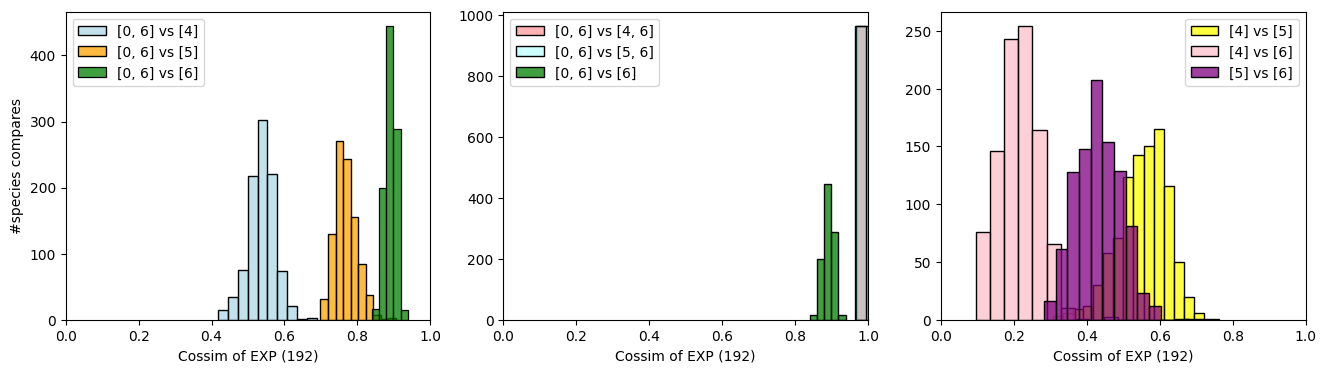

In [ ]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(16, 4)

xlabel = 'Cossim of EXP (192)'

sns.histplot(get_cossim(exp_old, exp4).rename(xlabel), ax=axs[0], label='[0, 6] vs [4]', bins=10, color='lightblue')
sns.histplot(get_cossim(exp_old, exp5).rename(xlabel), ax=axs[0], label='[0, 6] vs [5]', bins=10, color='orange')
sns.histplot(get_cossim(exp_old, exp6).rename(xlabel), ax=axs[0], label='[0, 6] vs [6]', bins=5, color='green')

sns.histplot(get_cossim(exp_old, exp456).rename(xlabel), ax=axs[1], label='[0, 6] vs [4, 6]', bins=1, alpha=0.3, color='red')
sns.histplot(get_cossim(exp_old, exp56).rename(xlabel), ax=axs[1], label='[0, 6] vs [5, 6]', bins=1, alpha=0.2, color='cyan')
sns.histplot(get_cossim(exp_old, exp6).rename(xlabel), ax=axs[1], label='[0, 6] vs [6]', bins=5, color='green')

sns.histplot(get_cossim(exp4, exp5).rename(xlabel), ax=axs[2], label='[4] vs [5]', bins=15, color='yellow')
sns.histplot(get_cossim(exp4, exp6).rename(xlabel), ax=axs[2], label='[4] vs [6]', bins=15, color='pink')
sns.histplot(get_cossim(exp6, exp5).rename(xlabel), ax=axs[2], label='[5] vs [6]', bins=15, color='purple')

axs[0].set_ylabel('#species compares')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
for ax in axs:
    ax.set_xlim(0, 1)
    ax.legend()
plt.savefig('./exp_cossim_ratecat_related.pdf', bbox_inches='tight')
plt.savefig('./exp_cossim_ratecat_related.jpg', bbox_inches='tight')
plt.show()

## compare new exp freqs with old ones LEGACY

In [36]:
spectra = pd.read_csv('./legacy/MutSpecVertebratescytb.csv')
spectra

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.000000,T>C,TTT,Actinopterygii
...,...,...,...,...,...,...,...,...,...,...
185659,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.0,15.981840,0.062571,A>G,AAA,Aves
185660,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.0,15.981840,0.000000,A>C,TAA,Aves
185661,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.0,15.981840,0.000000,A>C,GAA,Aves
185662,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.0,15.981840,0.000000,A>C,CAA,Aves


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


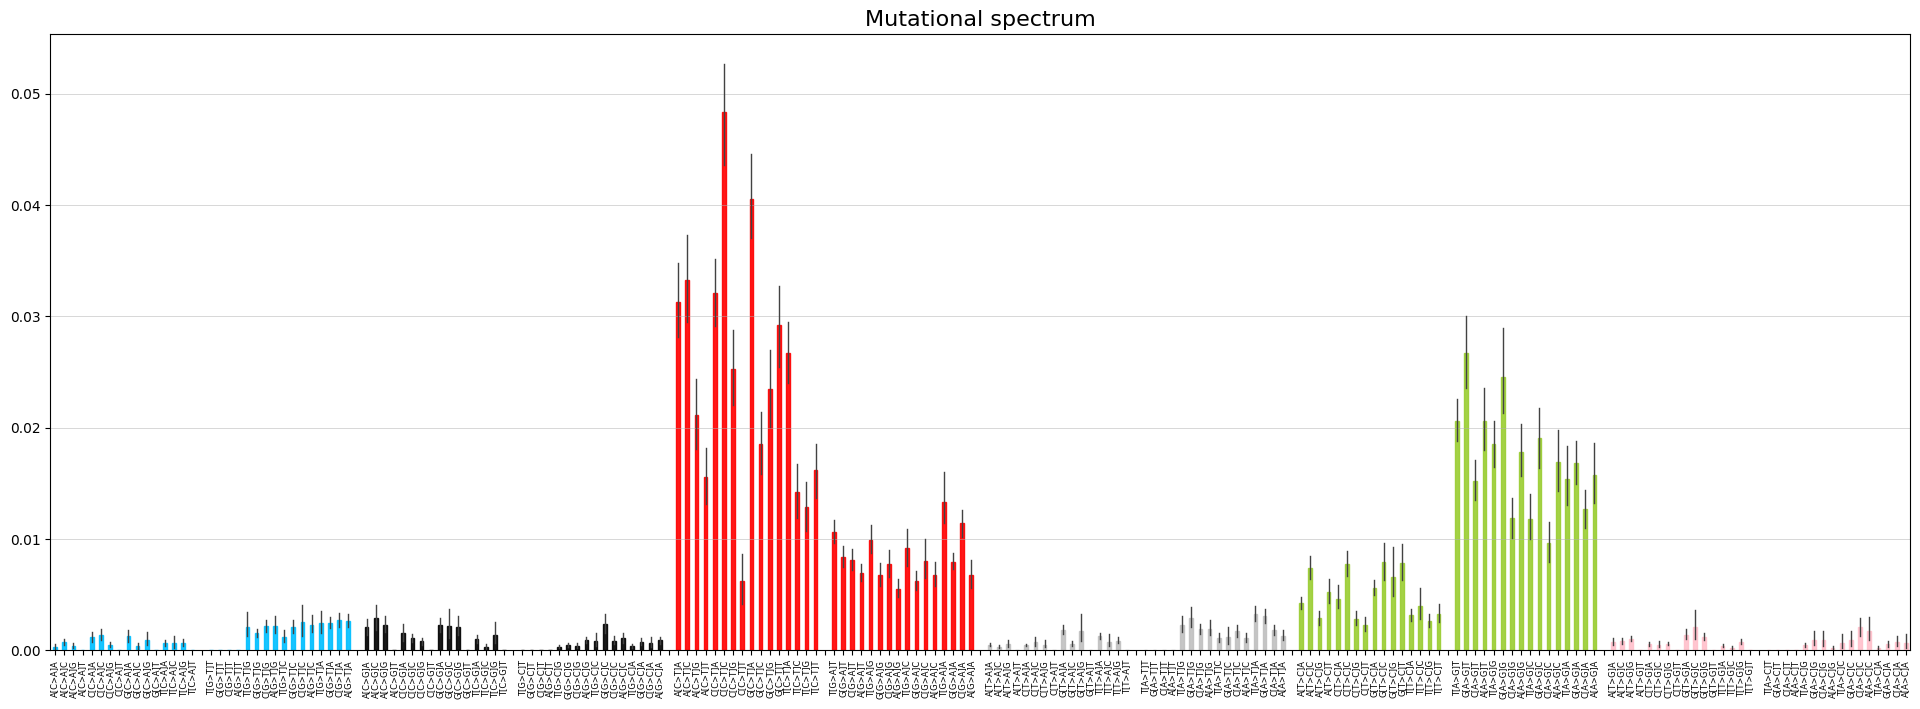

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [37]:
pymutspec.draw.plot_mutspec192(spectra)

In [38]:
exp_rate_freqs_long = exp_rate_freqs.stack().rename('exp_new').reset_index()
exp_rate_freqs_456_h = exp_rate_freqs_long.groupby(['species', 'Mut'])\
    .exp_new.sum().rename('exp_new456').reset_index()
exp_rate_freqs_56_h = exp_rate_freqs_long[exp_rate_freqs_long.rate > 4]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new56').reset_index()
exp_rate_freqs_6_h = exp_rate_freqs_long[exp_rate_freqs_long.rate == 6]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new6').reset_index()
exp_rate_freqs_5_h = exp_rate_freqs_long[exp_rate_freqs_long.rate == 5]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new5').reset_index()
exp_rate_freqs_4_h = exp_rate_freqs_long[exp_rate_freqs_long.rate == 4]\
    .groupby(['species', 'Mut']).exp_new.sum().rename('exp_new4').reset_index()

exp_rate_freqs_456_h['Mut'] = exp_rate_freqs_456_h['Mut'].apply(rev_comp)
exp_rate_freqs_56_h['Mut']  =  exp_rate_freqs_56_h['Mut'].apply(rev_comp)
exp_rate_freqs_6_h['Mut']   =   exp_rate_freqs_6_h['Mut'].apply(rev_comp)
exp_rate_freqs_5_h['Mut']   =   exp_rate_freqs_5_h['Mut'].apply(rev_comp)
exp_rate_freqs_4_h['Mut']   =   exp_rate_freqs_4_h['Mut'].apply(rev_comp)

In [39]:
exp_rate_freqs_h = exp_rate_freqs_456_h.merge(exp_rate_freqs_56_h, on=['species', 'Mut'])\
    .merge(exp_rate_freqs_6_h, on=['species', 'Mut'])\
        .merge(exp_rate_freqs_5_h, on=['species', 'Mut'])\
            .merge(exp_rate_freqs_4_h, on=['species', 'Mut'])

In [40]:
exp_rate_freqs_h

,species,Mut,exp_new456,exp_new56,exp_new6,exp_new5,exp_new4
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,0.0,0.0
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,0.0,0.0
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,0.0,0.0
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,0.0,0.0
4,Abbottina_obtusirostris,T[T>C]T,7.0,3.0,0.0,3.0,4.0
...,...,...,...,...,...,...,...
186811,Zosterops_japonicus,A[A>G]A,3.0,2.0,1.0,1.0,1.0
186812,Zosterops_japonicus,T[A>C]A,1.0,1.0,1.0,0.0,0.0
186813,Zosterops_japonicus,G[A>C]A,5.0,5.0,4.0,1.0,0.0
186814,Zosterops_japonicus,C[A>C]A,4.0,4.0,4.0,0.0,0.0


In [44]:
spectra2 = spectra.merge(exp_rate_freqs_h, right_on=['species', 'Mut'], 
                         left_on=['Species', 'Mut'])
spectra2

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class,species,exp_new456,exp_new56,exp_new6,exp_new5,exp_new4
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,TTT,Actinopterygii,Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.0
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,GTT,Actinopterygii,Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.0
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,CTT,Actinopterygii,Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.0
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,ATT,Actinopterygii,Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.0
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.000000,T>C,TTT,Actinopterygii,Abbottina_obtusirostris,7.0,3.0,0.0,3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184891,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.0,15.981840,0.062571,A>G,AAA,Aves,Zosterops_japonicus,3.0,2.0,1.0,1.0,1.0
184892,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.0,15.981840,0.000000,A>C,TAA,Aves,Zosterops_japonicus,1.0,1.0,1.0,0.0,0.0
184893,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.0,15.981840,0.000000,A>C,GAA,Aves,Zosterops_japonicus,5.0,5.0,4.0,1.0,0.0
184894,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.0,15.981840,0.000000,A>C,CAA,Aves,Zosterops_japonicus,4.0,4.0,4.0,0.0,0.0


### compare spectra directly

In [42]:
obs = spectra2.set_index(['Species', 'Mut']).Observed.unstack()
exp_old = spectra2.set_index(['Species', 'Mut']).Expected.unstack() 
exp456 = spectra2.set_index(['Species', 'Mut']).exp_new456.unstack()
exp56 = spectra2.set_index(['Species', 'Mut']).exp_new56.unstack()
exp6 = spectra2.set_index(['Species', 'Mut']).exp_new6.unstack()
exp5 = spectra2.set_index(['Species', 'Mut']).exp_new5.unstack()
exp4 = spectra2.set_index(['Species', 'Mut']).exp_new4.unstack()

In [43]:
obs.head()

Mut,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[A>T]A,A[A>T]C,...,T[T>A]G,T[T>A]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Species,,,,,,,,,,,,,,,,,,,,,
Abbottina_obtusirostris,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abbottina_rivularis,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,4.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0
Abramis_brama,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Acanthogobius_hasta,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Acanthopagrus_latus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
mutspec_old = (obs / exp_old).fillna(0).replace(np.inf, 0)
mutspec456 = (obs / exp456).fillna(0).replace(np.inf, 0)
mutspec56 = (obs / exp56).fillna(0).replace(np.inf, 0)
mutspec6 = (obs / exp6).fillna(0).replace(np.inf, 0)
mutspec5 = (obs / exp5).fillna(0).replace(np.inf, 0)
mutspec4 = (obs / exp4).fillna(0).replace(np.inf, 0)

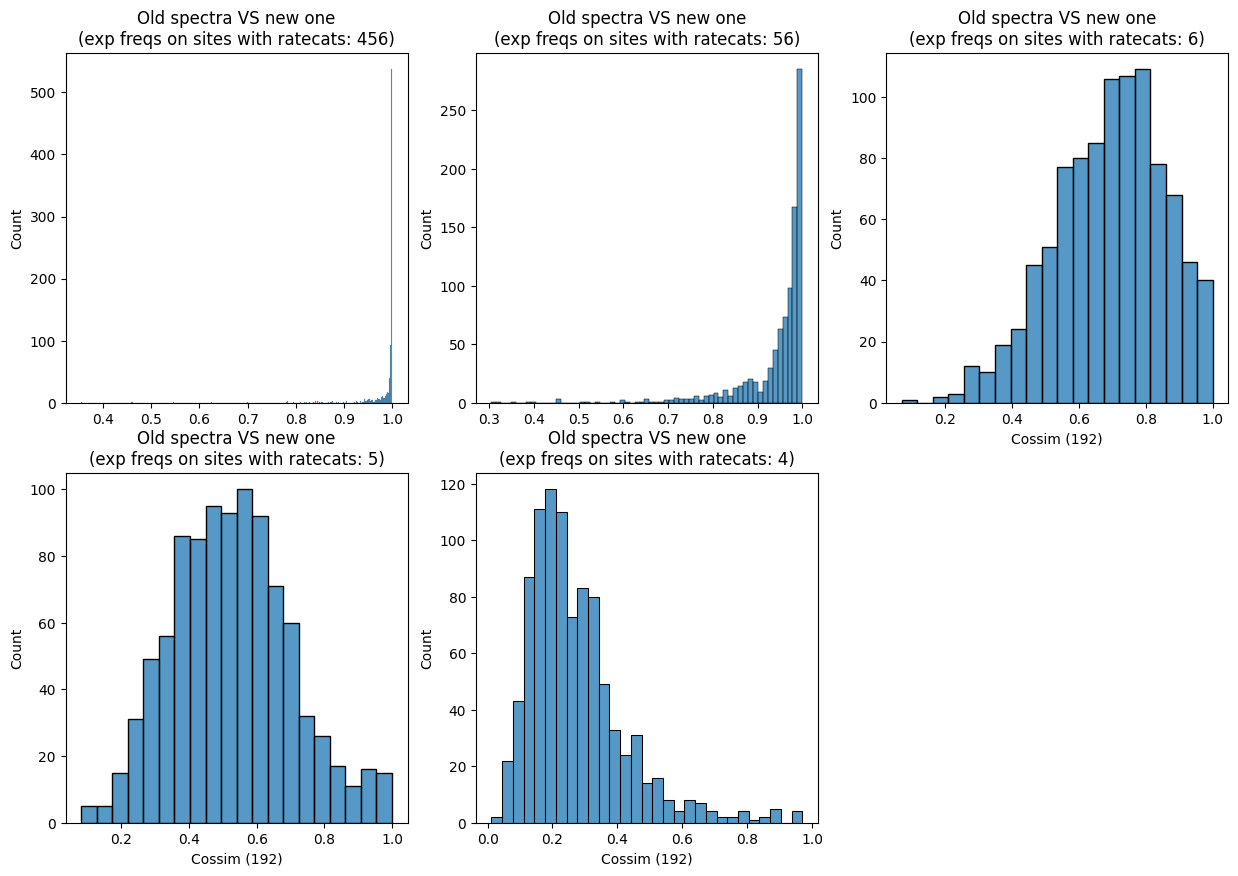

In [46]:
plt.figure(figsize=(15, 10))
for i, (new_spec, lbl) in enumerate(zip(
    [mutspec456, mutspec56, mutspec6, mutspec5, mutspec4], ['456', '56', '6', '5', '4']),1):

    cossim = get_cossim(mutspec_old, new_spec)
    plt.subplot(2, 3, i)
    plt.title(f'Old spectra VS new one\n(exp freqs on sites with ratecats: {lbl})')
    if i > 2:
        plt.xlabel('Cossim (192)')
    sns.histplot(cossim)
plt.show()

### Compare different exp freqs vectors

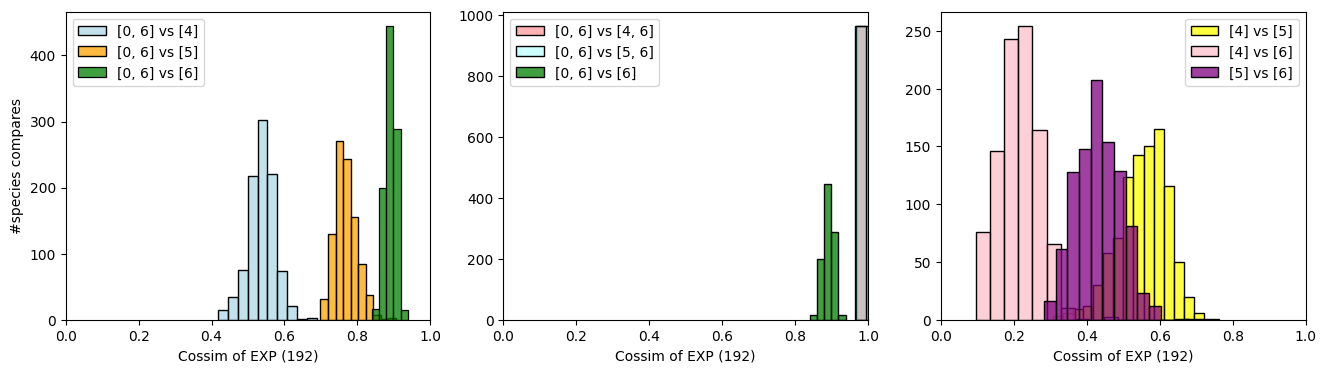

In [32]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(16, 4)

xlabel = 'Cossim of EXP (192)'

sns.histplot(get_cossim(exp_old, exp4).rename(xlabel), ax=axs[0], label='[0, 6] vs [4]', bins=10, color='lightblue')
sns.histplot(get_cossim(exp_old, exp5).rename(xlabel), ax=axs[0], label='[0, 6] vs [5]', bins=10, color='orange')
sns.histplot(get_cossim(exp_old, exp6).rename(xlabel), ax=axs[0], label='[0, 6] vs [6]', bins=5, color='green')

sns.histplot(get_cossim(exp_old, exp456).rename(xlabel), ax=axs[1], label='[0, 6] vs [4, 6]', bins=1, alpha=0.3, color='red')
sns.histplot(get_cossim(exp_old, exp56).rename(xlabel), ax=axs[1], label='[0, 6] vs [5, 6]', bins=1, alpha=0.2, color='cyan')
sns.histplot(get_cossim(exp_old, exp6).rename(xlabel), ax=axs[1], label='[0, 6] vs [6]', bins=5, color='green')

sns.histplot(get_cossim(exp4, exp5).rename(xlabel), ax=axs[2], label='[4] vs [5]', bins=15, color='yellow')
sns.histplot(get_cossim(exp4, exp6).rename(xlabel), ax=axs[2], label='[4] vs [6]', bins=15, color='pink')
sns.histplot(get_cossim(exp6, exp5).rename(xlabel), ax=axs[2], label='[5] vs [6]', bins=15, color='purple')

axs[0].set_ylabel('#species compares')
axs[1].set_ylabel('')
axs[2].set_ylabel('')
for ax in axs:
    ax.set_xlim(0, 1)
    ax.legend()
plt.savefig('./exp_cossim_ratecat_related.pdf', bbox_inches='tight')
plt.savefig('./exp_cossim_ratecat_related.jpg', bbox_inches='tight')
plt.show()